In [1]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd4843 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 24 × 12th Gen Intel(R) Core(TM) i9-12900K
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, alderlake)
Threads: 8 default, 0 interactive, 4 GC (on 24 virtual cores)
Environment:
  JULIA_NUM_THREADS = 8


In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `C:\Users\o6m1g\Documents\GitHub\SMC-LGO-CV-private`


Status `C:\Users\o6m1g\Documents\GitHub\SMC-LGO-CV-private\Project.toml`
  [0bf59076] AdvancedHMC v0.8.0
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.120
  [4138dd39] JLD v0.13.5
  [b964fa9f] LaTeXStrings v1.4.0
  [6fdf6af0] LogDensityProblems v2.1.2
  [86f7a689] NamedArrays v0.10.4
  [ce719bf2] PSIS v0.9.8
  [91a5bcdd] Plots v1.40.16
  [92933f4c] ProgressMeter v1.10.4
  [f2b01f46] Roots v2.2.8
  [2913bbd2] StatsBase v0.34.5
  [4c63d2b9] StatsFuns v1.5.0
  [f3b207a7] StatsPlots v0.15.7
  [fce5fe82] Turing v0.39.4
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random


# Setup

In [1]:
include("Init.jl")

In [2]:
println("Running on ", Threads.nthreads(), " threads.")

Running on 8 threads.


In [3]:
using Turing

In [4]:
RUN_MCMC = false
RUN_aSMC = true;

In [5]:
# Tag by timestamp
SESSION = Dates.format(now(), "yyyy-mm-dd-HH-MM-SS");

# Data

In [6]:
# Load data
df = CSV.read(joinpath("data", "radon", "radon.csv"), DataFrame)
first(df, 4)

Row,log_radon,floor,log_u,county
,Float64,Int64,Float64,String31
1,1.43508,0,0.165862,MARTIN
2,1.02962,0,-0.418054,RAMSEY
3,0.262364,0,-0.418054,RAMSEY
4,1.28093,0,-0.418054,RAMSEY


In [7]:
struct Data_Radon
    y::Vector{Float64}    # Response
    X::Matrix{Float64}    # Observation-level covariates
    U::Matrix{Float64}    # County-level covariates
    county::Vector{Int64} # County index for each observation (1 to G)
    N::Int64              # Total number of observations
    G::Int64              # Number of unique counties
    N_g::Vector{Int64}    # Observation count per county (length G)
end

In [8]:
# Construct data for "radon" example
let
    y = df.log_radon # Response variable
    X = [ones(size(df, 1)) df.floor] # Covariates
    N = length(y) # Total number of observations
    G = length(unique(df.county)) # Total number of unique counties

    # County-level covariate
    u = unique(df.log_u)
    @assert length(u) == G == 85 # Assert expected structure: exactly 85 counties and log_u values
    U = [ones(G) u]

    # Assign county index to each observation
    county_dict = Dict(g => g_i for (g_i, (g, _)) in enumerate(zip(unique(df.county), u)))
    county = [county_dict[g] for g in df.county]

    # Count observations per county → vector of length G
    N_g = sum(df.county .== permutedims(unique(df.county)); dims=1) |> vec

    # Assemble data structure for modeling
    global data = Data_Radon(y, X, U, county, N, G, N_g)
end

Data_Radon([1.4350845252893225, 1.0296194171811583, 0.26236426446749106, 1.2809338454620642, 1.7227665977411035, 1.7227665977411035, 0.26236426446749106, 1.6094379124341003, 1.410986973710262, 1.2809338454620642  …  1.3350010667323402, -0.5108256237659907, 0.09531017980432493, 0.4054651081081644, -0.6931471805599453, -0.5108256237659907, 0.5306282510621705, 0.0, 2.2192034840549946, 0.8329091229351041], [1.0 0.0; 1.0 0.0; … ; 1.0 1.0; 1.0 1.0], [1.0 0.16586183575526953; 1.0 -0.418053510614464; … ; 1.0 -0.7518722327017873; 1.0 -0.6633476306014291], [1, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  56, 13, 51, 52, 13, 13, 13, 13, 15, 82], 919, 85, [7, 32, 5, 3, 3, 6, 4, 4, 2, 11  …  12, 6, 5, 4, 4, 3, 4, 5, 3, 11])

# MCMC

In [9]:
@model function Model(
        data::Data_Radon,
        leave_g::Int64,
        ϕ::Union{Float64, Int64},
    )
    Γ ~ filldist(Normal(), 2, 2)
    v_y ~ InverseGamma(2, 1)
    v_β ~ filldist(Exponential(), 2)
    
    β = Vector(undef, data.G)
    for g in 1:data.G
        β[g] ~ MvNormal(Γ * data.U[g,:], v_β |> Diagonal)
    end
    
    for i in 1:data.N
        # Apply leave-one-group-out logic:
        # if observation belongs to leave_g, downweight likelihood by (1 - ϕ)
        _power = data.county[i] == leave_g ? (1 - ϕ) : 1
        Turing.@addlogprob! _power * logpdf(
            Normal(data.X[i,:]' * β[data.county[i]], v_y |> sqrt), data.y[i])
    end
    
    (; Γ, v_β, v_y, β)
end

Model (generic function with 2 methods)

In [10]:
function run_MCMC(; leave_g::Int64, save_bool::Bool=false)
    """
    Function to run MCMC, leaving (leave_g)-th group out.
    Set leave_g = -1 to target baseline posterior.
    """
    # Instantiate baseline posterior
    @assert leave_g ∈ [-1; 1:data.G]
    _model = nothing
    if leave_g == -1
        # leave_g = -1 ⟺ no leave-group-out
        # ϕ = 0 ⟺ full weight
        _model = Model(data, -1, 0)
    else
        # ϕ = 1 ⟺ no weight; case deleted
        _model = Model(data, leave_g, 1)
    end
    ℓπ = LogDensityFunction(_model)
    Turing.DynamicPPL.link!!(ℓπ.varinfo, _model)
    
    D = LogDensityProblems.dimension(ℓπ) # Dimensionality of parameter space
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)

    # Sampling settings
    n_burn, n_adapts, n_samples, thin = 1_000, 1_000, 3_000, 3 # By pilot run: abs autocorr is under 0.05 after 3 for majority of parameters
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
    
    time = @elapsed samples, stats = sample(
        hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts;
        progress=true)

    # Post-process samples:
    # - drop burn-in;
    # - apply thinning (every 3rd)
    # - invert bijector, recover params in original space
    chain = samples[n_burn+1:thin:end] .|> Turing.inverse(Turing.bijector(_model))

    # Save output
    if save_bool
        _dir = joinpath("output_$(SESSION)", "radon", "mcmc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        if leave_g == -1
            save(joinpath(_dir, "chain.jld"), "data", chain)
            CSV.write(joinpath(_dir, "stats_df.csv"), stats |> DataFrame)
        else
            save(joinpath(_dir, "chain_lgo-$(leave_g).jld"), "data", chain)
        end
    end
    
    (; chain, stats, time)
end

run_MCMC (generic function with 1 method)

## Initial draw

In [10]:
Random.seed!(1)
RUN_MCMC && ((; chain, stats, time) = run_MCMC(leave_g=-1; save_bool=true));

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Sampling 100%|███████████████████████████████| Time: 0:15:18
                                    iterations: 4000
                   ratio_divergent_transitions: 0.0
   ratio_divergent_transitions_during_adaption: 0.01
                                       n_steps: 31
                                     is_accept: true
                               acceptance_rate: 0.6337821096759917
                                   log_density: -1011.6894998218688
                            hamiltonian_energy: 1116.623272388024
                      hamiltonian_energy_error: 0.38121541874329523

## Naive LGO

In [12]:
Random.seed!(1)

if RUN_MCMC
    
    times_radon = Float64[] # Runtime for each MCMC-LGO run
    
    # Loop over each group for bruteforce MCMC-LGO
    for leave_g in 1:data.G
        @info "Leaving g=$(leave_g) out" 
        
        (; chain, stats, time) = run_MCMC(leave_g=leave_g; save_bool=true)
        push!(times_radon, time)
        
        # Save intermediate results after each iteration (in case of interruption)
        _dir = joinpath("output_$(SESSION)", "radon", "mcmc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        save(joinpath(_dir, "times_naive-lgo.jld"), "data", times_radon)
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Sampling 100%|███████████████████████████████| Time: 0:11:14
                                    iterations: 4000
                   ratio_divergent_transitions: 0.0
   ratio_divergent_transitions_during_adaption: 0.01
                                       n_steps: 15
                                     is_accept: true
                               acceptance_rate: 0.9614099185984277
                                   log_density: -959.3920399346343
                            hamiltonian_energy: 1053.451584473892
                      hamiltonian_energy_error: -0.11541114387546259

# LGO

In [11]:
chain = load(joinpath("output", "radon", "mcmc", "chain.jld"))["data"];
stats = CSV.read(joinpath("output", "radon", "mcmc", "stats_df.csv"), DataFrame);

## aSMC

In [12]:
function SMCS_Radon(chain::Vector{Vector{Float64}}, leave_g::Int64; k̂_threshold::Float64=0.7)
    
    # Unconstrain initial draws
    model   = Model(data, leave_g, 0) # draws are from this baseline
    draws_0 = chain .|> Turing.bijector(model) |> vecvec2mat # as matrix

    # Define problem dimensions
    R      = size(draws_0, 1)  # number of baseline MCMC draws
    D      = size(draws_0, 2)  # dimension of posterior
    L      = data.N_g[leave_g] # max number of intermediate distributions
    
    # Obtain unconstrained prior draw
    _names = sample(model, Prior(), 1).name_map.parameters .|> String # param names
    Θ_0    = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Allocate storage
    particles = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    weights   = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    ϕ_history = NamedArray(zeros(L+1), 0:L, :l)
    mcmc_flag = NamedArray(zeros(L+1), 0:L, :l)
    k̂         = nothing
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end
    
    # Effective sample size
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
    end
    
    # Log ratio at given proposal l-1 and target l for n-th particle
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end
    
    # MCMC kernel
    initial_ϵ, n_steps, mass = stats.step_size[end], min(15, stats.n_steps[end]), vec(var(chain .|> vec |> vecvec2mat; dims=1))
    function _move(initial_θ::Vector{Float64},
            n_samples::Int, n_adapts::Int,
            ℓπ::LogDensityFunction,
        )::Vector{Float64}
        
        metric = DiagEuclideanMetric(mass)
        hamiltonian = Hamiltonian(metric, ℓπ)
        integrator = Leapfrog(initial_ϵ)
        adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
        kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(n_steps)))
        
        rng = Random.TaskLocalRNG()
        samples, stats = sample(rng, hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts;
            verbose=false, progress=false)
        
        samples[end]
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0
    weights[:l => 0]   = repeat([1/R], R)
    ϕ_history[:l => 0] = 0.
    
    time = @elapsed for l in 1:L
        # Inherit case-deleted model from previous iteration
        model_0 = Model(data, leave_g, ϕ_history[:l => l-1])
        ℓπ_0 = LogDensityFunction(model_0)
        Turing.DynamicPPL.link!!(ℓπ_0.varinfo, model_0)

        # Define (until ↦ ESS) map
        function _ϕ2reff(ϕ::Union{Float64, Int64})::Float64
            @assert 0 ≤ ϕ ≤ 1
            model_1 = Model(data, leave_g, ϕ)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)
            
            _ESS = _log_weights |> _normalize |> _ess
            _ESS - R/2
        end
        
        # Initialize next distribution parameter
        ϕ_1 = nothing
        
        # Case 1: ESS is above threshold
        if _ϕ2reff(1) > 0
            # Define next as final distribution
            ϕ_1 = 1
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # Generalized Pareto
            _psis = psis(_log_weights; warn=false)
            
            # Case 1-1: PSIS
            if _psis.pareto_shape < k̂_threshold
                mcmc_flag[:l => l] = false; @info "ϕ=$(ϕ_1), PSIS"
                particles[:l => l] = particles[:l => l-1]
                weights[:l => l] = _psis.log_weights |> _normalize
                k̂ = _psis.pareto_shape 
                ϕ_history[:l => l] = ϕ_1
            
            # Case 1-2: MCMC kernel
            else
                mcmc_flag[:l => l] = true; @info "ϕ=$(ϕ_1), MCMC"
                
                A_0 = wsample(1:R, _log_weights |> _normalize, R)
                _begin = particles[:l => l-1, :n => A_0]
                _end = particles[:l => l, :n => 1:R] |> similar
                #@showprogress for n in 1:R
                p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                    _end[n,:] = _move(_begin[n,:], 1, 0, ℓπ_1)
                    ProgressMeter.next!(p)
                end
                particles[Name(l), :, :,] = _end
                weights[:l => l] = repeat([1/R], R)
                ϕ_history[:l => l] = ϕ_1
            end
            
            L = l; break # Break loop

        # Case 2: ESS is below threshold
        else
            mcmc_flag[:l => l] = true
            
            # Find next distribution
            ϕ_1 = find_zero(_ϕ2reff, (ϕ_history[:l => l-1] + 1e-4, 1),
                xtol=0.1, maxiters=10, verbose=true)
            @info "Targeting ϕ=$(ϕ_1)"
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # MCMC kernel
            A_0 = wsample(1:R, _log_weights |> _normalize, R)
            _begin = particles[:l => l-1, :n => A_0]
            _end = particles[:l => l, :n => 1:R] |> similar
            #@showprogress for n in 1:R
            p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                _end[n,:] = _move(_begin[n,:], 3, 0, ℓπ_1)
                ProgressMeter.next!(p)
            end
            particles[Name(l), :, :,] = _end
            weights[:l => l] = repeat([1/R], R)
            ϕ_history[:l => l] = ϕ_1
        end
    end

    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]
    mcmc_flag = mcmc_flag[Name(L)]
    ϕ_history = ϕ_history[Name.(0:L)]

    (;
        R,         # Number of particles
        D,         # Dimensionality of parameter space
        L,         # Number of intermediate distributions
        particles, # NamedArray of particles
        weights,   # Associated particle weights
        ϕ_history, # History of ϕ (= 1 - ρ | ρ: power coef) values
        k̂,         # Pareto shape diagnostic estimate, if any
        mcmc_flag, # true if invariant kernel applied
        time,      # SMC runtime
    )
end

SMCS_Radon (generic function with 1 method)

## PSIS

In [13]:
function PSIS_Radon(chain::Vector{Vector{Float64}}, leave_g::Int64; k̂_threshold::Float64=0.7)

    # Unconstrain initial draws
    model   = Model(data, leave_g, 0) # draws are from this baseline
    draws_0 = chain .|> Turing.bijector(model) |> vecvec2mat # as matrix

    # Define problem dimensions
    R      = size(draws_0, 1)  # number of baseline MCMC draws
    D      = size(draws_0, 2)  # dimension of posterior
    L      = 1                 # max number of intermediate distributions
    
    # Obtain unconstrained prior draw
    _names = sample(model, Prior(), 1).name_map.parameters .|> String # param names
    Θ_0    = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Allocate storage
    particles = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    weights   = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂         = nothing

    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end
    
    # Log ratio at given proposal l-1 and target l for n-th particle
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end

    # Set initial values, starting index
    particles[:l => 0] = Θ_0
    weights[:l => 0]   = repeat([1/R], R)
    
    time = @elapsed (l = 1;
        ϕ_0 = 0;
        model_0 = Model(data, leave_g, ϕ_0);
        ℓπ_0 = LogDensityFunction(model_0);
        Turing.DynamicPPL.link!!(ℓπ_0.varinfo, model_0);
        
        # Compute log weights
        ϕ_1 = 1;
        model_1 = Model(data, leave_g, ϕ_1);
        ℓπ_1 = LogDensityFunction(model_1);
        Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1);
        
        _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R];
        _log_weights = _log_weights .- maximum(_log_weights);

        # PSIS
        _psis = psis(_log_weights; warn=false);
        particles[:l => l] = particles[:l => l-1];
        weights[:l => l] = _psis.log_weights |> _normalize;
    )
    
    k̂ = _psis.pareto_shape
    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]

    (;
        R,         # Number of particles
        D,         # Dimensionality of parameter space
        L,         # = 1 distribution
        particles, # NamedArray of particles
        weights,   # Associated particle weights
        k̂,         # Pareto shape diagnostic estimate
        time,      # Runtime
    )
end

PSIS_Radon (generic function with 1 method)

# Run

In [56]:
# Function to run aSMC-LGO-CV or PSIS-LGO-CV across all counties
function run(
        use_chain::Vector{Vector{Float64}}, # Input baseline MCMC chain
        Sampler_Radon::Union{typeof(SMCS_Radon), typeof(PSIS_Radon)};
        save_bool::Bool=false,              # Saving output
        k̂_threshold::Float64=0.7,           # Optional threshold (unused for main analysis)
)
    
    R = length(use_chain) # Number of posterior particles

    # Init per-group storage
    particles    = []
    weights      = []
    ϕ_histories  = []
    k̂s           = []
    times        = Float64[]

    @info "First pilot run"
    Sampler_Radon(use_chain, 1; k̂_threshold=k̂_threshold)
    
    for leave_g in 1:data.G # Leave-out one group at a time
        @info "Leaving g=$(leave_g) out"
        
        # Run aSMC or PSIS
        results = Sampler_Radon(use_chain, leave_g; k̂_threshold=k̂_threshold)
        
        # Record output
        push!(particles,   results[:particles])
        push!(weights,     results[:weights])
        push!(k̂s,          results[:k̂])
        push!(times,       results[:time])
        Sampler_Radon == SMCS_Radon && push!(ϕ_histories, results[:ϕ_history])
        #break
    end

    if save_bool
        # Define folder to save output
        _dir = joinpath(
            "output_$(SESSION)",
            "radon",
            Sampler_Radon == SMCS_Radon ? "smc" : "psis"
        )
        isdir(_dir) || mkpath(_dir) # Ensure path is present

        # Save (after un-naming)
        # Sizes are: G = groups, R = particles, D = parameter dim
        save(joinpath(_dir, "particles_threshold-$(k̂_threshold).jld"),
            "data", particles .|> Matrix) # [G][R,D]
        save(joinpath(_dir, "weights_threshold-$(k̂_threshold).jld"),
            "data", weights .|> Vector) # [G][R]
        save(joinpath(_dir, "khats_threshold-$(k̂_threshold).jld"),
            "data", k̂s) # G
        save(joinpath(_dir, "times_threshold-$(k̂_threshold).jld"),
            "data", times) # G
        Sampler_Radon == SMCS_Radon && save(
            joinpath(_dir, "histories_threshold-$(k̂_threshold).jld"),
            "data", ϕ_histories .|> Vector) # [G][L_g]
    end
    
    return
end

run (generic function with 1 method)

In [57]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_Radon; save_bool=true);

[ Info: Leaving g=1 out


Results of univariate zero finding:

* Converged to: 0.6313816406249998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62811953124999975, 0.63464374999999984 )
(a₁₀, b₁₀) = ( 0.62811953124999975, 0.6313816406249998 )



[ Info: Targeting ϕ=0.6313816406249998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
[ Info: ϕ=1, PSIS
[ Info: Leaving g=2 out


Results of univariate zero finding:

* Converged to: 0.7325070312499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73250703124999983, 0.73576914062499987 )



[ Info: Targeting ϕ=0.7325070312499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17
[ Info: ϕ=1, PSIS
[ Info: Leaving g=3 out


Results of univariate zero finding:

* Converged to: 0.6379058593749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.63464374999999984, 0.66074062499999986 )
(a₈, b₈) = ( 0.63464374999999984, 0.64769218749999979 )
(a₉, b₉) = ( 0.63464374999999984, 0.64116796874999982 )
(a₁₀, b₁₀) = ( 0.63790585937499977, 0.64116796874999982 )



[ Info: Targeting ϕ=0.6379058593749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
[ Info: ϕ=1, PSIS
[ Info: Leaving g=4 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=5 out


Results of univariate zero finding:

* Converged to: 0.9086609374999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.89561249999999992, 0.92170937499999994 )
(a₈, b₈) = ( 0.89561249999999992, 0.90866093749999988 )
(a₉, b₉) = ( 0.9021367187499999, 0.90866093749999988 )
(a₁₀, b₁₀) = ( 0.90539882812499983, 0.90866093749999988 )



[ Info: Targeting ϕ=0.9086609374999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=6 out


Results of univariate zero finding:

* Converged to: 0.8858261718749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.84341874999999988, 0.89561249999999992 )
(a₇, b₇) = ( 0.8695156249999999, 0.89561249999999992 )
(a₈, b₈) = ( 0.88256406249999986, 0.89561249999999992 )
(a₉, b₉) = ( 0.88256406249999986, 0.88908828124999983 )
(a₁₀, b₁₀) = ( 0.88256406249999986, 0.88582617187499979 )



[ Info: Targeting ϕ=0.8858261718749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08
[ Info: ϕ=1, PSIS
[ Info: Leaving g=7 out
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
[ Info: Leaving g=8 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=9 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=10 out


Results of univariate zero finding:

* Converged to: 0.9575925781249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.94780624999999996, 1 )
(a₇, b₇) = ( 0.94780624999999996, 0.97390312499999998 )
(a₈, b₈) = ( 0.94780624999999996, 0.96085468749999992 )
(a₉, b₉) = ( 0.95433046874999994, 0.96085468749999992 )
(a₁₀, b₁₀) = ( 0.95433046874999994, 0.95759257812499987 )



[ Info: Targeting ϕ=0.9575925781249999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=11 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=12 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=13 out


Results of univariate zero finding:

* Converged to: 0.4874001953124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.43683749999999993, 0.48903124999999992 )
(a₆, b₆) = ( 0.4629343749999999, 0.48903124999999992 )
(a₇, b₇) = ( 0.47598281249999991, 0.48903124999999992 )
(a₈, b₈) = ( 0.48250703124999988, 0.48903124999999992 )
(a₉, b₉) = ( 0.48576914062499987, 0.48903124999999992 )
(a₁₀, b₁₀) = ( 0.4874001953124999, 0.48903124999999992 )



[ Info: Targeting ϕ=0.4874001953124999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


Results of univariate zero finding:

* Converged to: 0.7664674589157102
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.73750019531249988, 1 )
(a₁, b₁) = ( 0.73750019531249988, 0.86875009765624989 )
(a₂, b₂) = ( 0.73750019531249988, 0.80312514648437483 )
(a₃, b₃) = ( 0.73750019531249988, 0.77031267089843736 )
(a₄, b₄) = ( 0.75390643310546857, 0.77031267089843736 )
(a₅, b₅) = ( 0.76210955200195296, 0.77031267089843736 )
(a₆, b₆) = ( 0.76621111145019516, 0.77031267089843736 )
(a₇, b₇) = ( 0.76621111145019516, 0.7682618911743162 )
(a₈, b₈) = ( 0.76621111145019516, 0.76723650131225563 )
(a₉, b₉) = ( 0.76621111145019516, 0.76672380638122539 )
(a₁₀, b₁₀) = ( 0.76646745891571022, 0.76672380638122539 )



[ Info: Targeting ϕ=0.7664674589157102
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


Results of univariate zero finding:

* Converged to: 0.922607082326058
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.88328372945785505, 1 )
(a₁, b₁) = ( 0.88328372945785505, 0.94164186472892752 )
(a₂, b₂) = ( 0.91246279709339129, 0.94164186472892752 )
(a₃, b₃) = ( 0.91246279709339129, 0.92705233091115935 )
(a₄, b₄) = ( 0.91975756400227526, 0.92705233091115935 )
(a₅, b₅) = ( 0.91975756400227526, 0.92340494745671731 )
(a₆, b₆) = ( 0.92158125572949623, 0.92340494745671731 )
(a₇, b₇) = ( 0.92249310159310671, 0.92340494745671731 )
(a₈, b₈) = ( 0.92249310159310671, 0.92294902452491201 )
(a₉, b₉) = ( 0.92249310159310671, 0.92272106305900936 )
(a₁₀, b₁₀) = ( 0.92249310159310671, 0.92260708232605804 )



[ Info: Targeting ϕ=0.922607082326058
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


Results of univariate zero finding:

* Converged to: 0.9858472440782575
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.96135354116302896, 1 )
(a₁, b₁) = ( 0.98067677058151448, 1 )
(a₂, b₂) = ( 0.98067677058151448, 0.99033838529075724 )
(a₃, b₃) = ( 0.98550757793613586, 0.99033838529075724 )
(a₄, b₄) = ( 0.98550757793613586, 0.98792298161344649 )
(a₅, b₅) = ( 0.98550757793613586, 0.98671527977479112 )
(a₆, b₆) = ( 0.98550757793613586, 0.98611142885546343 )
(a₇, b₇) = ( 0.98580950339579965, 0.98611142885546343 )
(a₈, b₈) = ( 0.98580950339579965, 0.98596046612563149 )
(a₉, b₉) = ( 0.98580950339579965, 0.98588498476071551 )
(a₁₀, b₁₀) = ( 0.98580950339579965, 0.98584724407825752 )



[ Info: Targeting ϕ=0.9858472440782575
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=14 out


Results of univariate zero finding:

* Converged to: 0.9902136718749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.94780624999999996, 1 )
(a₇, b₇) = ( 0.97390312499999998, 1 )
(a₈, b₈) = ( 0.98695156249999993, 1 )
(a₉, b₉) = ( 0.98695156249999993, 0.99347578124999991 )
(a₁₀, b₁₀) = ( 0.99021367187499987, 0.99347578124999991 )



[ Info: Targeting ϕ=0.9902136718749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17
[ Info: ϕ=1, PSIS
[ Info: Leaving g=15 out


Results of univariate zero finding:

* Converged to: 0.6118089843749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.60854687499999982, 0.62159531249999977 )
(a₉, b₉) = ( 0.60854687499999982, 0.6150710937499998 )
(a₁₀, b₁₀) = ( 0.61180898437499975, 0.6150710937499998 )



[ Info: Targeting ϕ=0.6118089843749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16


Results of univariate zero finding:

* Converged to: 0.9278014272689816
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.80595449218749982, 1 )
(a₁, b₁) = ( 0.90297724609374985, 1 )
(a₂, b₂) = ( 0.90297724609374985, 0.95148862304687487 )
(a₃, b₃) = ( 0.92723293457031231, 0.95148862304687487 )
(a₄, b₄) = ( 0.92723293457031231, 0.93936077880859359 )
(a₅, b₅) = ( 0.92723293457031231, 0.93329685668945295 )
(a₆, b₆) = ( 0.92723293457031231, 0.93026489562988257 )
(a₇, b₇) = ( 0.92723293457031231, 0.92874891510009738 )
(a₈, b₈) = ( 0.92723293457031231, 0.92799092483520484 )
(a₉, b₉) = ( 0.92761192970275852, 0.92799092483520484 )
(a₁₀, b₁₀) = ( 0.92761192970275852, 0.92780142726898163 )



[ Info: Targeting ϕ=0.9278014272689816
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=16 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=17 out


Results of univariate zero finding:

* Converged to: 0.6574785156249998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.63464374999999984, 0.66074062499999986 )
(a₈, b₈) = ( 0.64769218749999979, 0.66074062499999986 )
(a₉, b₉) = ( 0.65421640624999977, 0.66074062499999986 )
(a₁₀, b₁₀) = ( 0.65747851562499982, 0.66074062499999986 )



[ Info: Targeting ϕ=0.6574785156249998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


Results of univariate zero finding:

* Converged to: 0.9832802009582519
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.8287892578124999, 1 )
(a₁, b₁) = ( 0.9143946289062499, 1 )
(a₂, b₂) = ( 0.95719731445312495, 1 )
(a₃, b₃) = ( 0.97859865722656247, 1 )
(a₄, b₄) = ( 0.97859865722656247, 0.98929932861328118 )
(a₅, b₅) = ( 0.97859865722656247, 0.98394899291992177 )
(a₆, b₆) = ( 0.98127382507324212, 0.98394899291992177 )
(a₇, b₇) = ( 0.98261140899658195, 0.98394899291992177 )
(a₈, b₈) = ( 0.98328020095825186, 0.98394899291992177 )
(a₉, b₉) = ( 0.98328020095825186, 0.98361459693908682 )
(a₁₀, b₁₀) = ( 0.98328020095825186, 0.98344739894866928 )



[ Info: Targeting ϕ=0.9832802009582519
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=18 out


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.58244999999999991, 0.60854687499999982 )
(a₈, b₈) = ( 0.58244999999999991, 0.59549843749999987 )
(a₉, b₉) = ( 0.58244999999999991, 0.58897421874999989 )
(a₁₀, b₁₀) = ( 0.58244999999999991, 0.58571210937499985 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19


Results of univariate zero finding:

* Converged to: 0.9904198486328124
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.79127499999999995, 1 )
(a₁, b₁) = ( 0.89563749999999998, 1 )
(a₂, b₂) = ( 0.94781874999999993, 1 )
(a₃, b₃) = ( 0.97390937499999997, 1 )
(a₄, b₄) = ( 0.98695468749999993, 1 )
(a₅, b₅) = ( 0.98695468749999993, 0.99347734374999996 )
(a₆, b₆) = ( 0.99021601562499995, 0.99347734374999996 )
(a₇, b₇) = ( 0.99021601562499995, 0.99184667968749995 )
(a₈, b₈) = ( 0.99021601562499995, 0.99103134765624989 )
(a₉, b₉) = ( 0.99021601562499995, 0.99062368164062486 )
(a₁₀, b₁₀) = ( 0.99041984863281241, 0.99062368164062486 )



[ Info: Targeting ϕ=0.9904198486328124
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10
[ Info: ϕ=1, PSIS
[ Info: Leaving g=19 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=20 out


Results of univariate zero finding:

* Converged to: 0.7064101562499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.69988593749999983, 0.7129343749999999 )
(a₉, b₉) = ( 0.69988593749999983, 0.70641015624999981 )
(a₁₀, b₁₀) = ( 0.70314804687499977, 0.70641015624999981 )



[ Info: Targeting ϕ=0.7064101562499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


Results of univariate zero finding:

* Converged to: 0.9710522712707517
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.8532550781249999, 1 )
(a₁, b₁) = ( 0.92662753906249995, 1 )
(a₂, b₂) = ( 0.96331376953124992, 1 )
(a₃, b₃) = ( 0.96331376953124992, 0.98165688476562496 )
(a₄, b₄) = ( 0.96331376953124992, 0.97248532714843738 )
(a₅, b₅) = ( 0.9678995483398436, 0.97248532714843738 )
(a₆, b₆) = ( 0.97019243774414043, 0.97248532714843738 )
(a₇, b₇) = ( 0.97019243774414043, 0.97133888244628885 )
(a₈, b₈) = ( 0.97076566009521459, 0.97133888244628885 )
(a₉, b₉) = ( 0.97076566009521459, 0.97105227127075167 )
(a₁₀, b₁₀) = ( 0.97090896568298313, 0.97105227127075167 )



[ Info: Targeting ϕ=0.9710522712707517
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=21 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=22 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=23 out


Results of univariate zero finding:

* Converged to: 0.9641167968749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.94780624999999996, 1 )
(a₇, b₇) = ( 0.94780624999999996, 0.97390312499999998 )
(a₈, b₈) = ( 0.96085468749999992, 0.97390312499999998 )
(a₉, b₉) = ( 0.96085468749999992, 0.96737890624999989 )
(a₁₀, b₁₀) = ( 0.96085468749999992, 0.96411679687499985 )



[ Info: Targeting ϕ=0.9641167968749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=24 out


Results of univariate zero finding:

* Converged to: 0.7390312499999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.73903124999999992, 0.79122499999999996 )
(a₇, b₇) = ( 0.73903124999999992, 0.76512812499999994 )
(a₈, b₈) = ( 0.73903124999999992, 0.75207968749999987 )
(a₉, b₉) = ( 0.73903124999999992, 0.74555546874999989 )
(a₁₀, b₁₀) = ( 0.73903124999999992, 0.74229335937499985 )



[ Info: Targeting ϕ=0.7390312499999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
[ Info: ϕ=1, PSIS
[ Info: Leaving g=25 out


Results of univariate zero finding:

* Converged to: 0.8238460937499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.79122499999999996, 0.84341874999999988 )
(a₇, b₇) = ( 0.81732187499999986, 0.84341874999999988 )
(a₈, b₈) = ( 0.81732187499999986, 0.83037031249999982 )
(a₉, b₉) = ( 0.81732187499999986, 0.82384609374999984 )
(a₁₀, b₁₀) = ( 0.8205839843749998, 0.82384609374999984 )



[ Info: Targeting ϕ=0.8238460937499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=26 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=27 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=28 out


Results of univariate zero finding:

* Converged to: 0.8629914062499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.84341874999999988, 0.89561249999999992 )
(a₇, b₇) = ( 0.84341874999999988, 0.8695156249999999 )
(a₈, b₈) = ( 0.85646718749999984, 0.8695156249999999 )
(a₉, b₉) = ( 0.86299140624999982, 0.8695156249999999 )
(a₁₀, b₁₀) = ( 0.86299140624999982, 0.86625351562499986 )



[ Info: Targeting ϕ=0.8629914062499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
[ Info: ϕ=1, PSIS
[ Info: Leaving g=29 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=30 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=31 out


Results of univariate zero finding:

* Converged to: 0.4955554687499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.48903124999999992, 0.53025624999999987 )
(a₇, b₇) = ( 0.48903124999999992, 0.50415937499999985 )
(a₈, b₈) = ( 0.48903124999999992, 0.49555546874999989 )
(a₉, b₉) = ( 0.49229335937499991, 0.49555546874999989 )
(a₁₀, b₁₀) = ( 0.49392441406249987, 0.49555546874999989 )



[ Info: Targeting ϕ=0.4955554687499999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


Results of univariate zero finding:

* Converged to: 0.8633891677856443
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.74565546874999988, 1 )
(a₁, b₁) = ( 0.74565546874999988, 0.87282773437499994 )
(a₂, b₂) = ( 0.80924160156249991, 0.87282773437499994 )
(a₃, b₃) = ( 0.84103466796874993, 0.87282773437499994 )
(a₄, b₄) = ( 0.85693120117187493, 0.87282773437499994 )
(a₅, b₅) = ( 0.85693120117187493, 0.86487946777343738 )
(a₆, b₆) = ( 0.86090533447265616, 0.86487946777343738 )
(a₇, b₇) = ( 0.86289240112304677, 0.86487946777343738 )
(a₈, b₈) = ( 0.86289240112304677, 0.86388593444824202 )
(a₉, b₉) = ( 0.86338916778564434, 0.86388593444824202 )
(a₁₀, b₁₀) = ( 0.86338916778564434, 0.86363755111694318 )



[ Info: Targeting ϕ=0.8633891677856443
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=32 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=33 out


Results of univariate zero finding:

* Converged to: 0.8075355468749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.79122499999999996, 0.84341874999999988 )
(a₇, b₇) = ( 0.79122499999999996, 0.81732187499999986 )
(a₈, b₈) = ( 0.80427343749999991, 0.81732187499999986 )
(a₉, b₉) = ( 0.80427343749999991, 0.81079765624999989 )
(a₁₀, b₁₀) = ( 0.80753554687499984, 0.81079765624999989 )



[ Info: Targeting ϕ=0.8075355468749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=34 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=35 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=36 out


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=37 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=38 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=39 out


Results of univariate zero finding:

* Converged to: 0.6607406249999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.63464374999999984, 0.66074062499999986 )
(a₈, b₈) = ( 0.64769218749999979, 0.66074062499999986 )
(a₉, b₉) = ( 0.65421640624999977, 0.66074062499999986 )
(a₁₀, b₁₀) = ( 0.65747851562499982, 0.66074062499999986 )



[ Info: Targeting ϕ=0.6607406249999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=40 out


Results of univariate zero finding:

* Converged to: 0.7814386718749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.73903124999999992, 0.79122499999999996 )
(a₇, b₇) = ( 0.76512812499999994, 0.79122499999999996 )
(a₈, b₈) = ( 0.77817656249999989, 0.79122499999999996 )
(a₉, b₉) = ( 0.77817656249999989, 0.78470078124999987 )
(a₁₀, b₁₀) = ( 0.77817656249999989, 0.78143867187499982 )



[ Info: Targeting ϕ=0.7814386718749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08
[ Info: ϕ=1, PSIS
[ Info: Leaving g=41 out


Results of univariate zero finding:

* Converged to: 0.6150710937499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.60854687499999982, 0.62159531249999977 )
(a₉, b₉) = ( 0.6150710937499998, 0.62159531249999977 )
(a₁₀, b₁₀) = ( 0.6150710937499998, 0.61833320312499973 )



[ Info: Targeting ϕ=0.6150710937499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=42 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=43 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=44 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=45 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=46 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=47 out


Results of univariate zero finding:

* Converged to: 0.4661964843749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.43683749999999993, 0.48903124999999992 )
(a₆, b₆) = ( 0.4629343749999999, 0.48903124999999992 )
(a₇, b₇) = ( 0.4629343749999999, 0.47598281249999991 )
(a₈, b₈) = ( 0.4629343749999999, 0.46945859374999988 )
(a₉, b₉) = ( 0.4629343749999999, 0.46619648437499989 )
(a₁₀, b₁₀) = ( 0.46456542968749986, 0.46619648437499989 )



[ Info: Targeting ϕ=0.4661964843749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


Results of univariate zero finding:

* Converged to: 0.8418020435333249
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.71629648437499982, 1 )
(a₁, b₁) = ( 0.71629648437499982, 0.85814824218749985 )
(a₂, b₂) = ( 0.78722236328124984, 0.85814824218749985 )
(a₃, b₃) = ( 0.82268530273437479, 0.85814824218749985 )
(a₄, b₄) = ( 0.84041677246093727, 0.85814824218749985 )
(a₅, b₅) = ( 0.84041677246093727, 0.84928250732421851 )
(a₆, b₆) = ( 0.84041677246093727, 0.84484963989257789 )
(a₇, b₇) = ( 0.84041677246093727, 0.84263320617675752 )
(a₈, b₈) = ( 0.84152498931884734, 0.84263320617675752 )
(a₉, b₉) = ( 0.84152498931884734, 0.84207909774780243 )
(a₁₀, b₁₀) = ( 0.84152498931884734, 0.84180204353332488 )



[ Info: Targeting ϕ=0.8418020435333249
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=48 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=49 out


Results of univariate zero finding:

* Converged to: 0.9249714843749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.92170937499999994, 0.94780624999999996 )
(a₈, b₈) = ( 0.92170937499999994, 0.9347578124999999 )
(a₉, b₉) = ( 0.92170937499999994, 0.92823359374999992 )
(a₁₀, b₁₀) = ( 0.92170937499999994, 0.92497148437499987 )



[ Info: Targeting ϕ=0.9249714843749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:12
[ Info: ϕ=1, PSIS
[ Info: Leaving g=50 out


Results of univariate zero finding:

* Converged to: 0.6770511718749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.66074062499999986, 0.68683749999999988 )
(a₈, b₈) = ( 0.67378906249999981, 0.68683749999999988 )
(a₉, b₉) = ( 0.67378906249999981, 0.68031328124999979 )
(a₁₀, b₁₀) = ( 0.67705117187499975, 0.68031328124999979 )



[ Info: Targeting ϕ=0.6770511718749997
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17
[ Info: ϕ=1, PSIS
[ Info: Leaving g=51 out


Results of univariate zero finding:

* Converged to: 0.9184472656249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.89561249999999992, 0.92170937499999994 )
(a₈, b₈) = ( 0.90866093749999988, 0.92170937499999994 )
(a₉, b₉) = ( 0.91518515624999985, 0.92170937499999994 )
(a₁₀, b₁₀) = ( 0.91518515624999985, 0.9184472656249999 )



[ Info: Targeting ϕ=0.9184472656249999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:12
[ Info: ϕ=1, PSIS
[ Info: Leaving g=52 out


Results of univariate zero finding:

* Converged to: 0.8890882812499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.84341874999999988, 0.89561249999999992 )
(a₇, b₇) = ( 0.8695156249999999, 0.89561249999999992 )
(a₈, b₈) = ( 0.88256406249999986, 0.89561249999999992 )
(a₉, b₉) = ( 0.88256406249999986, 0.88908828124999983 )
(a₁₀, b₁₀) = ( 0.88582617187499979, 0.88908828124999983 )



[ Info: Targeting ϕ=0.8890882812499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=53 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=54 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=55 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=56 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=57 out


Results of univariate zero finding:

* Converged to: 0.5041593749999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.48903124999999992, 0.53025624999999987 )
(a₇, b₇) = ( 0.50415937499999985, 0.53025624999999987 )
(a₈, b₈) = ( 0.50415937499999985, 0.51720781249999981 )
(a₉, b₉) = ( 0.50415937499999985, 0.51068359374999983 )
(a₁₀, b₁₀) = ( 0.50415937499999985, 0.50742148437499979 )



[ Info: Targeting ϕ=0.5041593749999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16


Results of univariate zero finding:

* Converged to: 0.9796668884277342
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.75212968749999987, 1 )
(a₁, b₁) = ( 0.87606484374999993, 1 )
(a₂, b₂) = ( 0.93803242187499991, 1 )
(a₃, b₃) = ( 0.9690162109374999, 1 )
(a₄, b₄) = ( 0.9690162109374999, 0.98450810546874989 )
(a₅, b₅) = ( 0.97676215820312484, 0.98450810546874989 )
(a₆, b₆) = ( 0.97676215820312484, 0.98063513183593731 )
(a₇, b₇) = ( 0.97869864501953108, 0.98063513183593731 )
(a₈, b₈) = ( 0.97869864501953108, 0.97966688842773419 )
(a₉, b₉) = ( 0.97918276672363258, 0.97966688842773419 )
(a₁₀, b₁₀) = ( 0.97942482757568339, 0.97966688842773419 )



[ Info: Targeting ϕ=0.9796668884277342
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14
[ Info: ϕ=1, PSIS
[ Info: Leaving g=58 out


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.58244999999999991, 0.60854687499999982 )
(a₈, b₈) = ( 0.58244999999999991, 0.59549843749999987 )
(a₉, b₉) = ( 0.58244999999999991, 0.58897421874999989 )
(a₁₀, b₁₀) = ( 0.58244999999999991, 0.58571210937499985 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


Results of univariate zero finding:

* Converged to: 0.9563797363281248
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.79127499999999995, 1 )
(a₁, b₁) = ( 0.89563749999999998, 1 )
(a₂, b₂) = ( 0.94781874999999993, 1 )
(a₃, b₃) = ( 0.94781874999999993, 0.97390937499999997 )
(a₄, b₄) = ( 0.94781874999999993, 0.96086406249999989 )
(a₅, b₅) = ( 0.95434140624999986, 0.96086406249999989 )
(a₆, b₆) = ( 0.95434140624999986, 0.95760273437499988 )
(a₇, b₇) = ( 0.95597207031249987, 0.95760273437499988 )
(a₈, b₈) = ( 0.95597207031249987, 0.95678740234374982 )
(a₉, b₉) = ( 0.95597207031249987, 0.95637973632812479 )
(a₁₀, b₁₀) = ( 0.95617590332031233, 0.95637973632812479 )



[ Info: Targeting ϕ=0.9563797363281248
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=59 out


Results of univariate zero finding:

* Converged to: 0.4759828124999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.43683749999999993, 0.48903124999999992 )
(a₆, b₆) = ( 0.4629343749999999, 0.48903124999999992 )
(a₇, b₇) = ( 0.4629343749999999, 0.47598281249999991 )
(a₈, b₈) = ( 0.46945859374999988, 0.47598281249999991 )
(a₉, b₉) = ( 0.47272070312499986, 0.47598281249999991 )
(a₁₀, b₁₀) = ( 0.47435175781249989, 0.47598281249999991 )



[ Info: Targeting ϕ=0.4759828124999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


Results of univariate zero finding:

* Converged to: 0.8368266754150389
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.72608281249999984, 1 )
(a₁, b₁) = ( 0.72608281249999984, 0.86304140624999992 )
(a₂, b₂) = ( 0.79456210937499983, 0.86304140624999992 )
(a₃, b₃) = ( 0.82880175781249987, 0.86304140624999992 )
(a₄, b₄) = ( 0.82880175781249987, 0.8459215820312499 )
(a₅, b₅) = ( 0.82880175781249987, 0.83736166992187488 )
(a₆, b₆) = ( 0.83308171386718732, 0.83736166992187488 )
(a₇, b₇) = ( 0.8352216918945311, 0.83736166992187488 )
(a₈, b₈) = ( 0.83629168090820294, 0.83736166992187488 )
(a₉, b₉) = ( 0.83682667541503886, 0.83736166992187488 )
(a₁₀, b₁₀) = ( 0.83682667541503886, 0.83709417266845687 )



[ Info: Targeting ϕ=0.8368266754150389
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: ϕ=1, PSIS
[ Info: Leaving g=60 out


Results of univariate zero finding:

* Converged to: 0.8988746093749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.89561249999999992, 0.92170937499999994 )
(a₈, b₈) = ( 0.89561249999999992, 0.90866093749999988 )
(a₉, b₉) = ( 0.89561249999999992, 0.9021367187499999 )
(a₁₀, b₁₀) = ( 0.89561249999999992, 0.89887460937499986 )



[ Info: Targeting ϕ=0.8988746093749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: ϕ=1, PSIS
[ Info: Leaving g=61 out


Results of univariate zero finding:

* Converged to: 0.6346437499999998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.63464374999999984, 0.66074062499999986 )
(a₈, b₈) = ( 0.63464374999999984, 0.64769218749999979 )
(a₉, b₉) = ( 0.63464374999999984, 0.64116796874999982 )
(a₁₀, b₁₀) = ( 0.63464374999999984, 0.63790585937499977 )



[ Info: Targeting ϕ=0.6346437499999998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15


Results of univariate zero finding:

* Converged to: 0.9297309753417967
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.81737187499999986, 1 )
(a₁, b₁) = ( 0.90868593749999993, 1 )
(a₂, b₂) = ( 0.90868593749999993, 0.95434296874999991 )
(a₃, b₃) = ( 0.90868593749999993, 0.93151445312499992 )
(a₄, b₄) = ( 0.92010019531249987, 0.93151445312499992 )
(a₅, b₅) = ( 0.92580732421874989, 0.93151445312499992 )
(a₆, b₆) = ( 0.92866088867187491, 0.93151445312499992 )
(a₇, b₇) = ( 0.92866088867187491, 0.93008767089843736 )
(a₈, b₈) = ( 0.92937427978515608, 0.93008767089843736 )
(a₉, b₉) = ( 0.92973097534179672, 0.93008767089843736 )
(a₁₀, b₁₀) = ( 0.92973097534179672, 0.92990932312011698 )



[ Info: Targeting ϕ=0.9297309753417967
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


Results of univariate zero finding:

* Converged to: 0.9934901783764362
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.9649154876708983, 1 )
(a₁, b₁) = ( 0.98245774383544915, 1 )
(a₂, b₂) = ( 0.99122887191772457, 1 )
(a₃, b₃) = ( 0.99122887191772457, 0.99561443595886223 )
(a₄, b₄) = ( 0.9934216539382934, 0.99561443595886223 )
(a₅, b₅) = ( 0.9934216539382934, 0.99451804494857776 )
(a₆, b₆) = ( 0.9934216539382934, 0.99396984944343558 )
(a₇, b₇) = ( 0.9934216539382934, 0.99369575169086444 )
(a₈, b₈) = ( 0.9934216539382934, 0.99355870281457892 )
(a₉, b₉) = ( 0.9934216539382934, 0.99349017837643616 )
(a₁₀, b₁₀) = ( 0.99345591615736473, 0.99349017837643616 )



[ Info: Targeting ϕ=0.9934901783764362
Progress: 100%|█████████████████████████████████████████| Time: 0:03:12
[ Info: ϕ=1, PSIS
[ Info: Leaving g=62 out


Results of univariate zero finding:

* Converged to: 0.7553417968749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.73903124999999992, 0.79122499999999996 )
(a₇, b₇) = ( 0.73903124999999992, 0.76512812499999994 )
(a₈, b₈) = ( 0.75207968749999987, 0.76512812499999994 )
(a₉, b₉) = ( 0.75207968749999987, 0.75860390624999985 )
(a₁₀, b₁₀) = ( 0.7553417968749998, 0.75860390624999985 )



[ Info: Targeting ϕ=0.7553417968749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09
[ Info: ϕ=1, PSIS
[ Info: Leaving g=63 out


Results of univariate zero finding:

* Converged to: 0.4270511718749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.41074062499999991, 0.43683749999999993 )
(a₇, b₇) = ( 0.42378906249999992, 0.43683749999999993 )
(a₈, b₈) = ( 0.42378906249999992, 0.4303132812499999 )
(a₉, b₉) = ( 0.42705117187499991, 0.4303132812499999 )
(a₁₀, b₁₀) = ( 0.42705117187499991, 0.42868222656249988 )



[ Info: Targeting ϕ=0.4270511718749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


Results of univariate zero finding:

* Converged to: 0.9214947673797605
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.67715117187499985, 1 )
(a₁, b₁) = ( 0.83857558593749992, 1 )
(a₂, b₂) = ( 0.91928779296874996, 1 )
(a₃, b₃) = ( 0.91928779296874996, 0.95964389648437498 )
(a₄, b₄) = ( 0.91928779296874996, 0.93946584472656247 )
(a₅, b₅) = ( 0.91928779296874996, 0.92937681884765622 )
(a₆, b₆) = ( 0.91928779296874996, 0.92433230590820303 )
(a₇, b₇) = ( 0.91928779296874996, 0.92181004943847644 )
(a₈, b₈) = ( 0.9205489212036132, 0.92181004943847644 )
(a₉, b₉) = ( 0.92117948532104477, 0.92181004943847644 )
(a₁₀, b₁₀) = ( 0.92117948532104477, 0.92149476737976055 )



[ Info: Targeting ϕ=0.9214947673797605
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08
[ Info: ϕ=1, PSIS
[ Info: Leaving g=64 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=65 out


Results of univariate zero finding:

* Converged to: 0.8042734374999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.79122499999999996, 0.84341874999999988 )
(a₇, b₇) = ( 0.79122499999999996, 0.81732187499999986 )
(a₈, b₈) = ( 0.80427343749999991, 0.81732187499999986 )
(a₉, b₉) = ( 0.80427343749999991, 0.81079765624999989 )
(a₁₀, b₁₀) = ( 0.80427343749999991, 0.80753554687499984 )



[ Info: Targeting ϕ=0.8042734374999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:15
[ Info: ϕ=1, PSIS
[ Info: Leaving g=66 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=67 out


Results of univariate zero finding:

* Converged to: 0.8760398437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.84341874999999988, 0.89561249999999992 )
(a₇, b₇) = ( 0.8695156249999999, 0.89561249999999992 )
(a₈, b₈) = ( 0.8695156249999999, 0.88256406249999986 )
(a₉, b₉) = ( 0.8695156249999999, 0.87603984374999988 )
(a₁₀, b₁₀) = ( 0.87277773437499984, 0.87603984374999988 )



[ Info: Targeting ϕ=0.8760398437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14
[ Info: ϕ=1, PSIS
[ Info: Leaving g=68 out


Results of univariate zero finding:

* Converged to: 0.9217093749999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.92170937499999994, 0.94780624999999996 )
(a₈, b₈) = ( 0.92170937499999994, 0.9347578124999999 )
(a₉, b₉) = ( 0.92170937499999994, 0.92823359374999992 )
(a₁₀, b₁₀) = ( 0.92170937499999994, 0.92497148437499987 )



[ Info: Targeting ϕ=0.9217093749999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
[ Info: ϕ=1, PSIS
[ Info: Leaving g=69 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=70 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=71 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=72 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=73 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=74 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=75 out


Results of univariate zero finding:

* Converged to: 0.7259828124999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.7129343749999999, 0.72598281249999985 )
(a₉, b₉) = ( 0.71945859374999988, 0.72598281249999985 )
(a₁₀, b₁₀) = ( 0.72272070312499981, 0.72598281249999985 )



[ Info: Targeting ϕ=0.7259828124999999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
[ Info: ϕ=1, PSIS
[ Info: Leaving g=76 out


Results of univariate zero finding:

* Converged to: 0.6803132812499998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.66074062499999986, 0.68683749999999988 )
(a₈, b₈) = ( 0.67378906249999981, 0.68683749999999988 )
(a₉, b₉) = ( 0.68031328124999979, 0.68683749999999988 )
(a₁₀, b₁₀) = ( 0.68031328124999979, 0.68357539062499983 )



[ Info: Targeting ϕ=0.6803132812499998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09
[ Info: ϕ=1, PSIS
[ Info: Leaving g=77 out


Results of univariate zero finding:

* Converged to: 0.9249714843749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.92170937499999994, 0.94780624999999996 )
(a₈, b₈) = ( 0.92170937499999994, 0.9347578124999999 )
(a₉, b₉) = ( 0.92170937499999994, 0.92823359374999992 )
(a₁₀, b₁₀) = ( 0.92497148437499987, 0.92823359374999992 )



[ Info: Targeting ϕ=0.9249714843749999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
[ Info: ϕ=1, PSIS
[ Info: Leaving g=78 out


Results of univariate zero finding:

* Converged to: 0.9184472656249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.89561249999999992, 1 )
(a₆, b₆) = ( 0.89561249999999992, 0.94780624999999996 )
(a₇, b₇) = ( 0.89561249999999992, 0.92170937499999994 )
(a₈, b₈) = ( 0.90866093749999988, 0.92170937499999994 )
(a₉, b₉) = ( 0.91518515624999985, 0.92170937499999994 )
(a₁₀, b₁₀) = ( 0.9184472656249999, 0.92170937499999994 )



[ Info: Targeting ϕ=0.9184472656249999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:11
[ Info: ϕ=1, PSIS
[ Info: Leaving g=79 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=80 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=81 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=82 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=83 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=84 out
[ Info: ϕ=1, PSIS
[ Info: Leaving g=85 out
[ Info: ϕ=1, PSIS


In [58]:
Random.seed!(1)
RUN_aSMC && run(chain, PSIS_Radon; save_bool=true);

[ Info: Leaving g=1 out
[ Info: Leaving g=2 out
[ Info: Leaving g=3 out
[ Info: Leaving g=4 out
[ Info: Leaving g=5 out
[ Info: Leaving g=6 out
[ Info: Leaving g=7 out
[ Info: Leaving g=8 out
[ Info: Leaving g=9 out
[ Info: Leaving g=10 out
[ Info: Leaving g=11 out
[ Info: Leaving g=12 out
[ Info: Leaving g=13 out
[ Info: Leaving g=14 out
[ Info: Leaving g=15 out
[ Info: Leaving g=16 out
[ Info: Leaving g=17 out
[ Info: Leaving g=18 out
[ Info: Leaving g=19 out
[ Info: Leaving g=20 out
[ Info: Leaving g=21 out
[ Info: Leaving g=22 out
[ Info: Leaving g=23 out
[ Info: Leaving g=24 out
[ Info: Leaving g=25 out
[ Info: Leaving g=26 out
[ Info: Leaving g=27 out
[ Info: Leaving g=28 out
[ Info: Leaving g=29 out
[ Info: Leaving g=30 out
[ Info: Leaving g=31 out
[ Info: Leaving g=32 out
[ Info: Leaving g=33 out
[ Info: Leaving g=34 out
[ Info: Leaving g=35 out
[ Info: Leaving g=36 out
[ Info: Leaving g=37 out
[ Info: Leaving g=38 out
[ Info: Leaving g=39 out
[ Info: Leaving g=40 out
[ Info: L

# Figures

## LPD

In [11]:
function Compute_LPDs(results, leave_g::Int64, _model, _names; constrain=true)::Vector{Float64}

    # compute log predictive density (LPD) for a single particle
    function LPD(particle)::Float64
        # Transform particle to named space for convenience
        particle = NamedArray(
            constrain ? particle |> Turing.inverse(Turing.bijector(_model)) : particle,
            _names, # Label parameters
            :d      # Use :d as axis name
        )
        β = particle[:d => ["β[$(leave_g)][$(k)]" for k in 1:2]]
        v_y = particle[:d => "v_y"]
        logpdf(MvNormal(X_g * β, v_y * I), y_g)
    end

    # Subset y and X for observations in group leave_g
    leave_g_idx = data.county .== leave_g
    y_g, X_g = data.y[leave_g_idx], data.X[leave_g_idx,:]
    @assert data.N_g[leave_g] == sum(leave_g_idx) # Assert size matches known count

    # Compute LPDs for each posterior particle
    LPDs = Float64[]
    for n in 1:results.R
        push!(LPDs, results[:particles][:n => n] |> LPD)
    end
    
    LPDs
end

Compute_LPDs (generic function with 1 method)

In [16]:
k̂_threshold = .7

0.7

In [17]:
let
    # Prepare dimensions and containers
    R                   = length(load(joinpath("output", "radon", "mcmc", "chain.jld"))["data"])
    LPD_template        = NamedArray(zeros(R, data.G), (1:R, 1:data.G), (:n, :g))
    global LPD_mcmc     = similar(LPD_template)
    global LPD_smc      = similar(LPD_template)
    global LPD_psis     = similar(LPD_template)
    global weights_smc  = load(joinpath("output", "radon", "smc",
            "weights_threshold-$(k̂_threshold).jld"))["data"]
    global weights_psis = load(joinpath("output", "radon", "psis",
            "weights_threshold-$(0.7).jld"))["data"]
    
    # Helper to wrap chain into NamedArray for Compute_LPDs
    function _wrap_particles(_particles::Vector)
        R = length(_particles)
        results = (; particles=NamedArray(_particles, 1:R, :n), R=R)
    end

    # Pre-load/instantiate particles / baseline posterior
    chain_smc = load(joinpath("output", "radon", "smc",
            "particles_threshold-$(k̂_threshold).jld"))["data"]
    chain_psis = load(joinpath("output", "radon", "psis",
            "particles_threshold-$(0.7).jld"))["data"]
    _model = Model(data, -1, 0) # leave_g = -1 to disable leave-group-out logic
    _names = sample(_model, Prior(), 1).name_map.parameters .|> String # Parameter names
    
    # Loop over all groups
    @info "Computing LPDs."; sleep(0.01)
    @showprogress for leave_g in 1:data.G
        # @info "Leaving g=$(leave_g) out"
        
        # MCMC as ground truth
        chain = load(joinpath("output", "radon", "mcmc", "chain_lgo-$(leave_g).jld"))["data"]
        LPD_mcmc[:, leave_g] = Compute_LPDs(
            chain |> _wrap_particles,
            leave_g, _model, _names;
            constrain=false) # LGO draws are already constrained to original space
    
        # SMC estimate
        LPD_smc[:, leave_g] = Compute_LPDs(
            chain_smc[leave_g] |> mat2vecvec |> _wrap_particles,
            leave_g, _model, _names;
            constrain=true)
    
        # PSIS estimate
        LPD_psis[:, leave_g] = Compute_LPDs(
            chain_psis[leave_g] |> mat2vecvec |> _wrap_particles,
            leave_g, _model, _names;
            constrain=true)
    end
end

[ Info: Computing LPDs.
Progress: 100%|█████████████████████████████████████████| Time: 0:05:16


In [22]:
let
    R, G = size(LPD_mcmc)
    equal_weights_cumsum = cumsum(fill(1/R, R))
    COUNTIES = unique(df.county)
    COUNTMAP = countmap(df.county)
    re_idx = sortperm([sum(df.county .== g) for g in COUNTIES], rev=true)
    
    # Plot
    n_rows = 2
    plts = []; for (g_i, g) in enumerate([1,2,3, data.G-2, data.G-1, data.G]) # 3 highest-/lowest-N groups 
        
        # Plot where PSIS distribution approximation "ends"
        vline([minimum(LPD_psis[:, re_idx[g]])], label="", ylim=(0,1),
            color=:green, alpha=0.75, linewidth=1, linestyle=:dash)

        # MCMC empirical cdf
        plot!(sort(LPD_mcmc[:, re_idx[g]]),
            equal_weights_cumsum,
            color=:blue, label="", linewidth=4, alpha=0.8)

        # SMC empirical cdf
        cdf_sort_idx = LPD_smc[:, re_idx[g]] |> sortperm
        plot!(LPD_smc[cdf_sort_idx, re_idx[g]],
            weights_smc[re_idx[g]][cdf_sort_idx] |> cumsum,
            color=:red, label="", linewidth=3, linestyle=:dot, alpha=.75)

        # PSIS empirical cdf
        cdf_sort_idx = LPD_psis[:, re_idx[g]] |> sortperm
        plot!(LPD_psis[cdf_sort_idx, re_idx[g]],
            weights_psis[re_idx[g]][cdf_sort_idx] |> cumsum,
            color=:green, label="", linewidth=2, linestyle=:dash, alpha=1)
        
        if g_i == 1
            annotate!(-157, 0.35, text("MCMC", :blue, 8))
            annotate!(-166, 0.20, text("aSMC", :red, 8))
            annotate!(-144, 0.10, text("PSIS", :green, 8))
        end
        
        push!(plts, plot!(
                title="$(COUNTIES[re_idx[g]]) (" * L"N_g" * "=$(COUNTMAP[COUNTIES[re_idx[g]]]))",
                legend=g == 1 ? true : false,
                xlim=(LPD_smc[:, re_idx[g]] |> minimum, LPD_mcmc[:, re_idx[g]] |> maximum)))
    end
    
    plot(plts..., layout=(n_rows, 3), size=(600,150n_rows),
        tick_direction=:out,
        titlefontsize=11,
        ytickfontsize=7, yticks=0:0.25:1,
        xtickfontsize=6, xrot=30,
        topmargin=2Plots.mm, bottommargin=3Plots.mm,
        xlabel=["" "" "" "" "Log predictive density" ""],
    )# |> display

    _dir = "img_$(SESSION)" * (k̂_threshold == 0.7 ? "" : "_threshold-$(k̂_threshold)")
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "radon-lpd-compare.pdf"))
end;

## Distributions

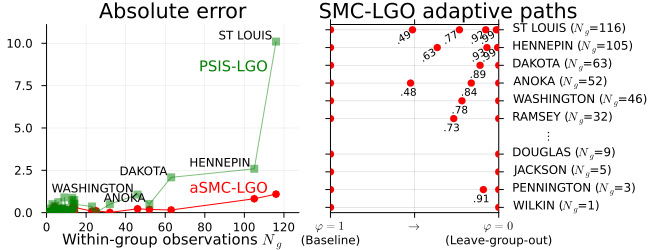

In [42]:
let
    R, G = size(LPD_mcmc)
    equal_weights_cumsum = cumsum(fill(1/R, R))
    COUNTIES = unique(df.county)
    COUNTMAP = countmap(df.county)
    re_idx = sortperm([sum(df.county .== g) for g in COUNTIES], rev=true)
    
    est_mcmc = _mean(LPD_mcmc; dims=1)[re_idx]
    est_smc  = _sum(vecvec2mat(weights_smc)' .* LPD_smc; dims=1)[re_idx]
    est_psis = _sum(vecvec2mat(weights_psis)' .* LPD_psis; dims=1)[re_idx]
    
    loss_smc = abs.(est_mcmc - est_smc)
    loss_psis = abs.(est_mcmc - est_psis)
    
    plot(data.N_g[re_idx], loss_smc, color=:red,
        ms=4, mswidth=0, label="", alpha=1, markershape=:o, linestyle=:solid)
    plot!(data.N_g[re_idx], loss_psis, color=:green,
        ms=4, mswidth=0, label="", alpha=0.5, markershape=:square, linestyle=:solid)

    for i in 1:5
        _x = data.N_g[re_idx[i]]
        annotate!(_x, loss_psis[i], text("$(COUNTIES[re_idx[i]]) \n", 8, :right))#1 ≤ i ≤ 3 ? 8 : 7))

        if i == 1
            annotate!(_x + 3, loss_smc[i] + 0.4, text("aSMC-LGO   ", 10, :right, :red))
            annotate!(_x + 3, loss_psis[i], text("\n\n\nPSIS-LGO   ", 10, :right, :green))
        end
    end
    plt_loss = plot!(xlim=(0, 1.1maximum(data.N_g)), ylim=(0, 1.1maximum([loss_psis; loss_smc])))

    # k̂_threshold = 0.7
    histories = load(joinpath("output", "radon", "smc", "histories_threshold-$(k̂_threshold).jld"))["data"]
    
    plot()
    select_idx = [1:6; -1; Int.(round.(LinRange(6, data.G, 4+1)[2:end]))]
    #for (g, (i, history)) in enumerate(zip(select_idx, histories[re_idx][select_idx]))
    for (i, g) in enumerate(select_idx)
        g == -1 && continue
        history = histories[re_idx[g]]
        for ℓ in history
            if 0 < ℓ < 1
                if g <= 2
                    annotate!(ℓ, i + 0.50, text("$(round(ℓ; digits=2))"[2:end], :right, :black, :bottom, 7, rotation=30))
                else
                    annotate!(ℓ, i + 0.5, text("$(round(ℓ; digits=2)) "[2:end], :right, :black, :center, 7))
                end
            end
        end
        scatter!(history, repeat([i], length(history)), ms=4, mswidth=0.1, color=:red, label="")
    end

    _offset = 0.000
    plot!(
        xlim=(0-_offset, 1+_offset),
        xticks=(
            [0, 0.5, 1],
            [L"\varphi = 1" * "\n(Baseline)", L"\rightarrow", L"\varphi = 0" * "\n(Leave-group-out)"]
        ),
        yticks=Tuple(eachcol(vcat([permutedims([i, prod([COUNTIES[re_idx[g]], " (", L"N_g", "=", "$(COUNTMAP[COUNTIES[re_idx[g]]]))"])]) for (i, g) in enumerate(select_idx) if g != -1]...))),
        ymirror=true, ytickfontsize=8,
        framestyle=:box,
        yflip=true
    )
    plt_dist = annotate!(1.3, 6+1, text(L"\vdots", 9))

    plot(plt_loss, plt_dist, layout=grid(1,2,widths=[0.6,0.4]), size=(650,250),
        title=["Absolute error" repeat(" ", 10) * "SMC-LGO adaptive paths"], #titlefontsize=14,
        xlabel=["Within-group observations " * L"N_g" ""], xlabelfontsize=10,
        rightmargin=[3Plots.mm 0Plots.mm], bottommargin=2Plots.mm,
        tick_direction=:out
    ) |> display

    _dir = "img_$(SESSION)" * (k̂_threshold == 0.7 ? "" : "_threshold-$(k̂_threshold)")
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "radon-lpd-error.pdf"))
end;

## Runtime

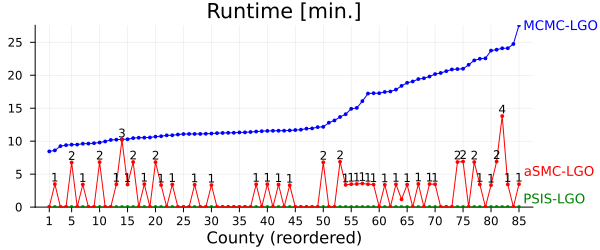

In [43]:
let
    # k̂_threshold = 0.7
    time_mcmc = load(joinpath("output", "radon", "mcmc",
            "times_naive-lgo.jld"))["data"] / 60
    time_smc  = load(joinpath("output", "radon", "smc",
            "times_threshold-$(k̂_threshold).jld"))["data"] / 60
    time_psis = load(joinpath("output", "radon", "psis",
            "times_threshold-$(0.7).jld"))["data"] / 60
    
    re_idx = time_mcmc |> sortperm
    time_mcmc = time_mcmc[re_idx]
    time_smc  = time_smc[re_idx]
    time_psis = time_psis[re_idx]

    COUNTIES = unique(df.county)[re_idx]
    COUNTMAP = df.county |> countmap

    plot(time_mcmc, markershape=:o, ms=2, mswidth=0, color=:blue)
    plot!(time_psis, markershape=:o, ms=2, mswidth=0, color=:green)
    plot!(time_smc, markershape=:o, ms=2, mswidth=0, color=:red)
    
    annotate!(data.G + 1, time_mcmc[end], text("MCMC-LGO", :blue, :left, 9))
    annotate!(data.G + 1, time_smc[end] + 2, text("aSMC-LGO", :red, :left, 9))
    annotate!(data.G + 1, time_psis[end] + 1.3, text("PSIS-LGO", :green, :left, 9))

    
    histories = load(joinpath("output", "radon", "smc",
            "histories_threshold-$(k̂_threshold).jld"))["data"]
    for (g, history) in enumerate(histories[re_idx])
        L_g = length(history) - 1
        if L_g == 1
            # annotate!(g, time_smc[g] - 0.1, text(L_g-1, :red, :top, 5))
        else
            annotate!(g, time_smc[g], text(L_g-1, :black, 8, :bottom))
        end
    end
    plot!(tick_direction=:out,
        ylim=(0, maximum([time_mcmc; time_smc; time_psis])),
        xticks=sort(unique([0:5:data.G; 1; data.G][2:end])),
        xlabel="County (reordered)", title="Runtime [min.]",
        legend=false, size=(600, 250),
        rightmargin=15Plots.mm, bottommargin=3Plots.mm
    ) |> display
    
    _dir = "img_$(SESSION)" * (k̂_threshold == 0.7 ? "" : "_threshold-$(k̂_threshold)")
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "radon-runtime.pdf"))
end;